In [187]:
#Create zipcodes database 
import pandas as pd
import requests
import json
import matplotlib
import matplotlib.pyplot as plt
import geopandas as gpd
import panel as pn
from panel.interact import interact
import plotly.express as px
import time
import os
import calendar
from PIL import Image
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [103]:
pn.extension('plotly')

In [245]:
## cREATE Zillow Observed Rent index database


zori_df = pd.read_csv('resources/ZORI.csv')
zori_sf = zori_df.loc[zori_df['MsaName']== "San Francisco, CA"].reset_index(drop=True)
zori_sf.rename(columns = {'RegionName':'zip'}, inplace= True)
zori_sf= zori_sf.set_index('zip', drop = True)
zori_sf = zori_sf.iloc[:,-9:]
zori_sf = zori_sf.reset_index()
zori_sf = zori_sf.sort_values('zip')
zori_sf['zip'] = zori_sf['zip'].astype(str)
zori_sf = zori_sf.set_index('zip')
zori_sf = zori_sf.loc['94102':'94134']

In [188]:
#create rental average over all zip codes and create plot
average_df = pd.DataFrame()
col = zori_sf.loc[: , '1/1/2020 0:00':'9/1/2020 0:00']
average_df['SF rent average'] = col.mean(axis=0)
average_df = average_df.reset_index()
average_df.rename(columns = {'index':'date'}, inplace = True)
average_df['date'] = pd.to_datetime(average_df['date']).dt.month_name().str.slice(stop=3)
average_df

ImportError: cannot import name 'OrderedDict' from 'pandas.compat' (C:\Users\Kiel\anaconda3\envs\pyvizenv\lib\site-packages\pandas\compat\__init__.py)

  date  SF rent average
0  Jan      3726.111111
1  Feb      3725.235294
2  Mar      3692.222222
3  Apr      3678.666667
4  May      3656.611111
5  Jun      3660.277778
6  Jul      3618.444444
7  Aug      3494.294118
8  Sep      3456.222222

In [157]:
#create Zillow Home Value Index
import calendar
zhvi_df = pd.read_csv('resources/zhvi.csv')
zhvi_sf = zhvi_df.loc[zhvi_df['RegionName']== "San Francisco, CA"].reset_index(drop=True)
zhvi_sf = zhvi_sf[zhvi_sf.columns[2:303]]
zhvi_sf = zhvi_sf.drop(columns = ['RegionType', 'StateName'])
zhvi_sf = zhvi_sf.transpose().reset_index()
zhvi_sf = zhvi_sf.rename(columns = zhvi_sf.iloc[0])
zhvi_sf = zhvi_sf.drop(zhvi_sf.index[0])
zhvi_sf = zhvi_sf.rename(columns = {'RegionName':'date','San Francisco, CA':'ZHVI'})
zhvi_sf = zhvi_sf.loc[zhvi_sf['date'] >= '2020-01-31']
zhvi_sf['date'] = pd.to_datetime(zhvi_sf['date']).dt.month_name().str.slice(stop=3)
zhvi_sf

ImportError: cannot import name 'OrderedDict' from 'pandas.compat' (C:\Users\Kiel\anaconda3\envs\pyvizenv\lib\site-packages\pandas\compat\__init__.py)

    date         ZHVI
289  Jan  1.08917e+06
290  Feb  1.09511e+06
291  Mar  1.09994e+06
292  Apr  1.10052e+06
293  May  1.09698e+06
294  Jun  1.09457e+06
295  Jul  1.09653e+06
296  Aug  1.10565e+06
297  Sep  1.11366e+06

In [260]:
#Create rental rate by zip code figure
zori_month = zori_sf
zori_month = zori_month.transpose().reset_index()
zori_month['index'] = pd.to_datetime(zori_month['index']).dt.month_name().str.slice(stop=3)

#replace na with zipcode average
zori_month['94112'] =zori_month['94112'].fillna(zori_month['94112'].mean())
zori_month['94132'] =zori_month['94132'].fillna(zori_month['94132'].mean())



#create FIg
rental_by_zip = zori_month.hvplot.line(
    xlabel = "Date",
    rot = 90,
    ylabel = "Rental Price",
    title = "Rental Rate by San Francisco Zip Code"
)
rental_by_zip

:NdOverlay   [Variable]
   :Curve   [index]   (value)

In [165]:
# Create comparison housing figure with secondary y-axis
housing_fig = make_subplots(specs=[[{"secondary_y": True}]])

#
x_zhvi = zhvi_sf['date']
y_zhvi = zhvi_sf['ZHVI']
x_av = average_df['date']
y_av = average_df['SF rent average']

# Add traces
housing_fig.add_trace(
    go.Scatter(x=x_zhvi, y=y_zhvi, name="Average Rent Price (MM)"),
    secondary_y=False,
)

housing_fig.add_trace(
    go.Scatter(x=x_av, y=y_av, name="Average House Price"),
    secondary_y=True,
)

#set titles
housing_fig.update_xaxes(title_text = 'Month')


housing_fig.show()

In [11]:
#Pull most recent corona virus infection for SF zip codes
corona_geo_url = "https://data.sfgov.org/resource/tpyr-dvnc.json"
data = requests.get(corona_geo_url).json()
corona_geo = pd.DataFrame(data)
corona_geo_zipcode = corona_geo.loc[corona_geo['area_type'] == 'ZCTA'].reset_index(drop=True)
corona_geo_zipcode['count']= corona_geo_zipcode['count'].fillna(0)
corona_geo_zipcode['rate']= corona_geo_zipcode['rate'].fillna(0)
corona_geo_zipcode['deaths']= corona_geo_zipcode['deaths'].fillna(0)
corona_geo_zipcode['count']= corona_geo_zipcode['count'].astype('float')
corona_geo_zipcode.rename(columns = {'id':'Zip_Code'}, inplace = True)
corona_geo_zipcode['last_updated_at'] = pd.to_datetime(corona_geo_zipcode['last_updated_at']).dt.date
corona_geo_zipcode['last_updated_at'] = pd.to_datetime(corona_geo_zipcode['last_updated_at']).astype(str) +' 0:00'
corona_geo_zipcode['last_updated_at'] = pd.to_datetime(corona_geo_zipcode['last_updated_at']).dt.strftime('%m/%d/%Y')
corona_geo_zipcode['last_updated_at'] = pd.to_datetime(corona_geo_zipcode['last_updated_at']).astype(str) +' 0:00'


In [12]:
#load june corona virus infection for SF zips 
corona_jun = pd.read_csv('resources/zip_covid_jun.csv')
jun_df = pd.DataFrame(corona_jun)
jun_df = jun_df.loc[jun_df['area_type'] == 'ZCTA'].reset_index(drop=True)
jun_df['count']= jun_df['count'].fillna(0)
jun_df['rate']= jun_df['rate'].fillna(0)
jun_df['deaths']= jun_df['deaths'].fillna(0)
jun_df.rename(columns = {'id':'Zip_Code'}, inplace = True)
jun_df.rename(columns = {'data_loaded_at':'last_updated_at'}, inplace= True)
jun_df = jun_df[['area_type', 'Zip_Code', 'count', 'rate', 'deaths', 'acs_population', 'last_updated_at', 'multipolygon']]
jun_df['last_updated_at'] = pd.to_datetime(jun_df['last_updated_at']).dt.date
jun_df['last_updated_at'] = pd.to_datetime(jun_df['last_updated_at']).dt.strftime('%m/%d/%Y')
jun_df['last_updated_at'] = pd.to_datetime(jun_df['last_updated_at']).astype(str) +' 12:00'


In [13]:
#load oct corona virus infection for SF zips 
corona_oct = pd.read_csv('resources/zip_covid_oct.csv')
oct_df = pd.DataFrame(corona_oct)
oct_df = oct_df.loc[oct_df['area_type'] == 'ZCTA'].reset_index(drop=True)
oct_df['count']= oct_df['count'].fillna(0)
oct_df['rate']= oct_df['rate'].fillna(0)
oct_df['deaths']= oct_df['deaths'].fillna(0)
oct_df.rename(columns = {'id':'Zip_Code'}, inplace = True)
oct_df.drop(columns = 'last_updated_at', inplace = True)
oct_df.rename(columns = {'data_loaded_at':'last_updated_at'}, inplace= True)
oct_df = oct_df[['area_type', 'Zip_Code', 'count', 'rate', 'deaths', 'acs_population', 'last_updated_at', 'multipolygon']]
oct_df['last_updated_at'] = pd.to_datetime(oct_df['last_updated_at']).dt.date
oct_df['last_updated_at'] = pd.to_datetime(oct_df['last_updated_at']).astype(str) +' 12:00'
oct_df['last_updated_at'] = pd.to_datetime(oct_df['last_updated_at']).dt.strftime('%m/%d/%Y')
oct_df['last_updated_at'] = pd.to_datetime(oct_df['last_updated_at']).astype(str) +' 12:00'


In [14]:
#create Kepler map
from keplergl import KeplerGl
map1=KeplerGl(height = 700)

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


In [15]:
#add datasets to Kepler map
map1.add_data(data= jun_df, name = 'Jun Corona')
map1.add_data(data= oct_df, name = 'Oct Corona')
map1.add_data(data= corona_geo_zipcode, name = 'Current Corona')

In [16]:
map1

KeplerGl(data={'Jun Corona': {'index': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, …

In [975]:
map1.save_to_html(file_name='resources/Corona infection rate by zip code Jun to Current')

Map saved to resources/Corona infection rate by zip code Jun to Current!


In [17]:
#SF geogpandas zip code geometry database

fp = 'resources/geo_export_3591227c-4863-43a3-80a3-948e0e6fec37.shp'
map_df = gpd.read_file(fp)
map_df = map_df.loc[map_df['po_name'] == 'SAN FRANCISCO']
map_df = map_df.sort_values('zip')
map_df = map_df.set_index('zip')
map_df = map_df.loc['94102':'94134']

In [18]:
# Relabel zori_sf column headers to months, fill NaN with column averages
zori_sf_months = zori_sf.rename(index=str, columns =
{'1/1/2020 0:00' : 'Jan',
'2/1/2020 0:00' : 'Feb',
'3/1/2020 0:00' : 'Mar',
'4/1/2020 0:00' : 'Apr',
'5/1/2020 0:00' : 'May',
'6/1/2020 0:00' : 'Jun',
'7/1/2020 0:00' : 'Jul',
'8/1/2020 0:00' : 'Aug',
'9/1/2020 0:00' : 'Sep',})
zori_sf_months['Feb'] = zori_sf_months['Feb'].fillna(zori_sf_months['Feb'].mean())
zori_sf_months['Aug'] = zori_sf_months['Feb'].fillna(zori_sf_months['Aug'].mean())

In [19]:
# join map and zori_sf_months df
merged = map_df.join(zori_sf_months)

In [20]:
# drop Na
merged = merged.dropna()

In [21]:
#Global map min/max set by zori_sf min/max rent
vmin = zori_sf_months.max().max()
vmax = zori_sf_months.min().min()



In [23]:
#map imports and create list of months
output_path = 'resources'
list_of_months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep']

<IPython.core.display.Javascript object>


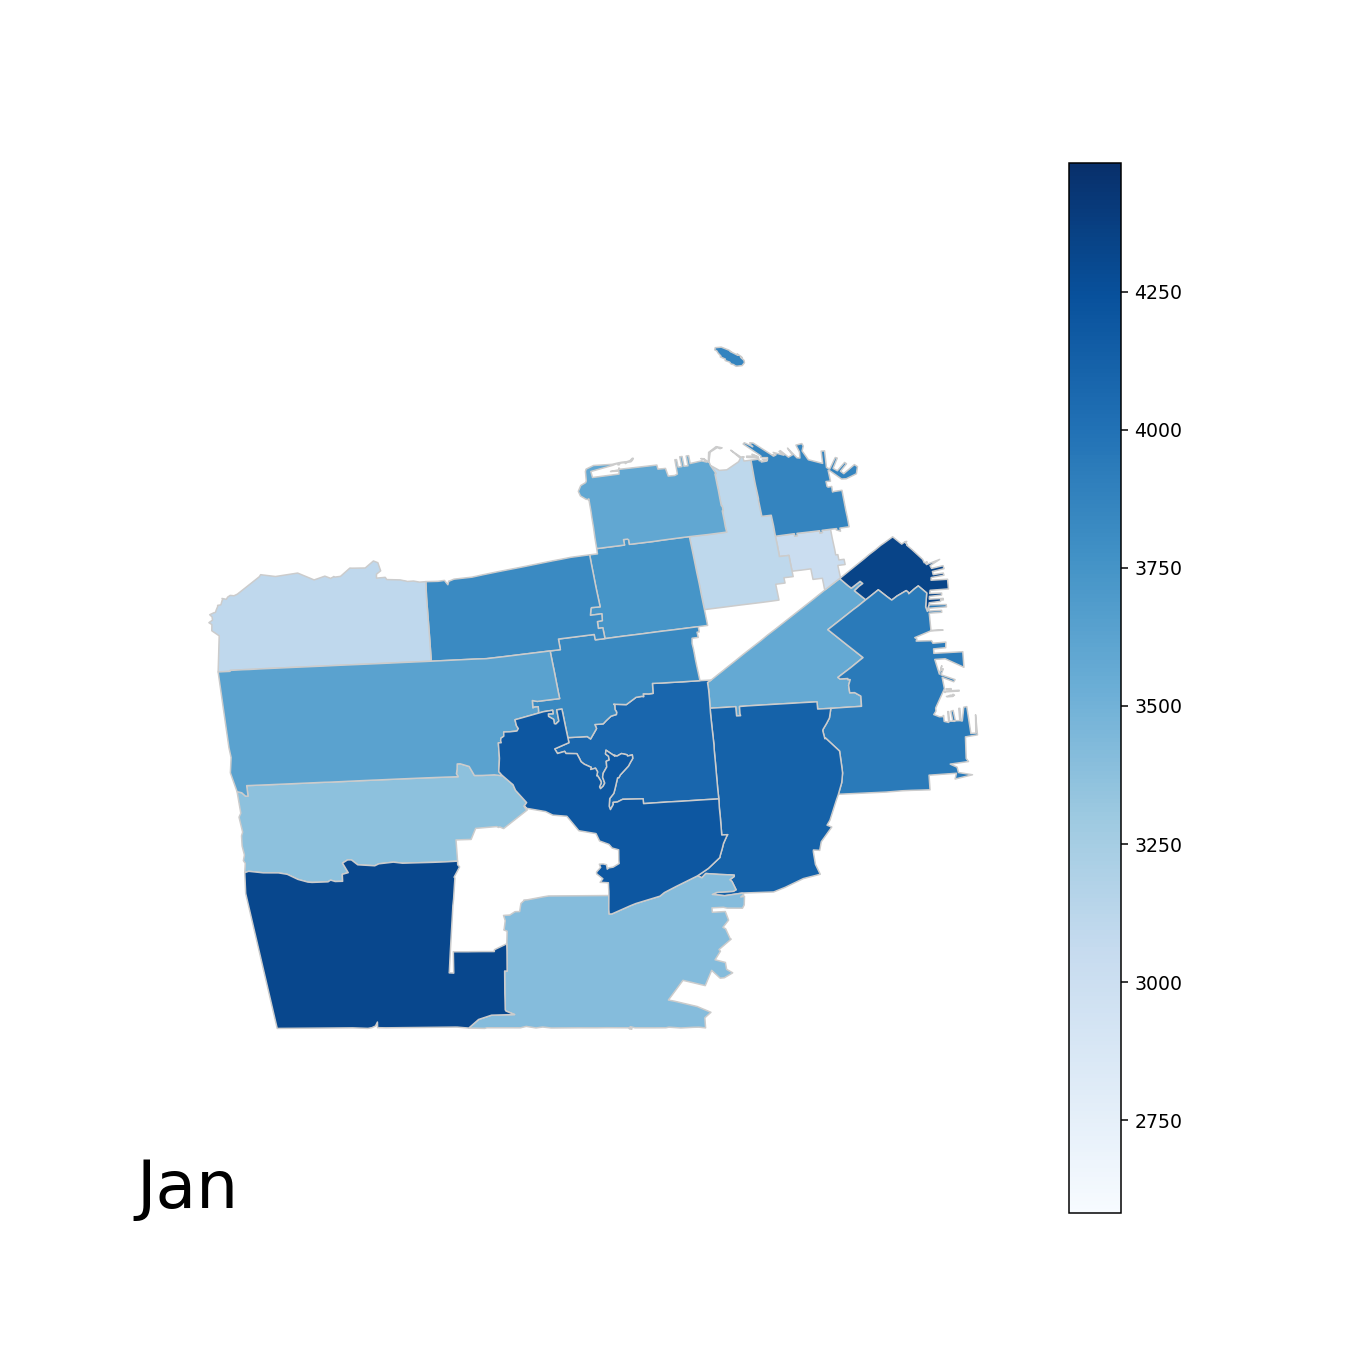

<IPython.core.display.Javascript object>


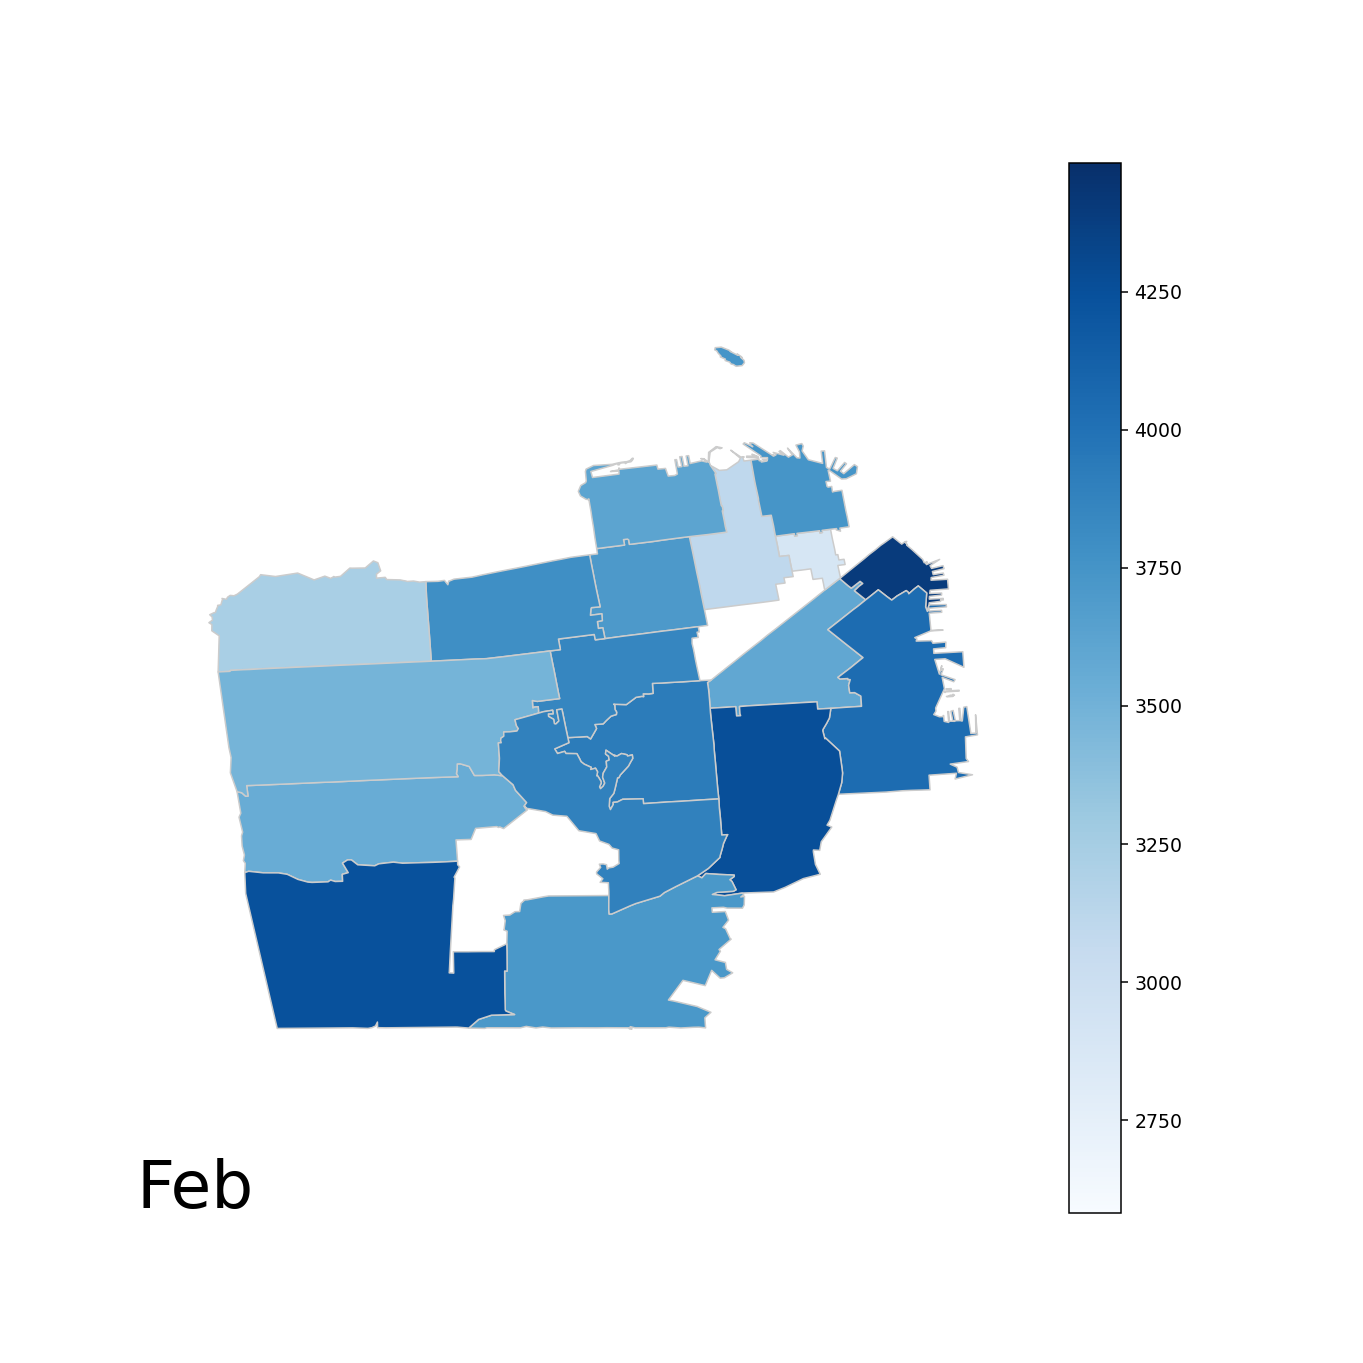

<IPython.core.display.Javascript object>


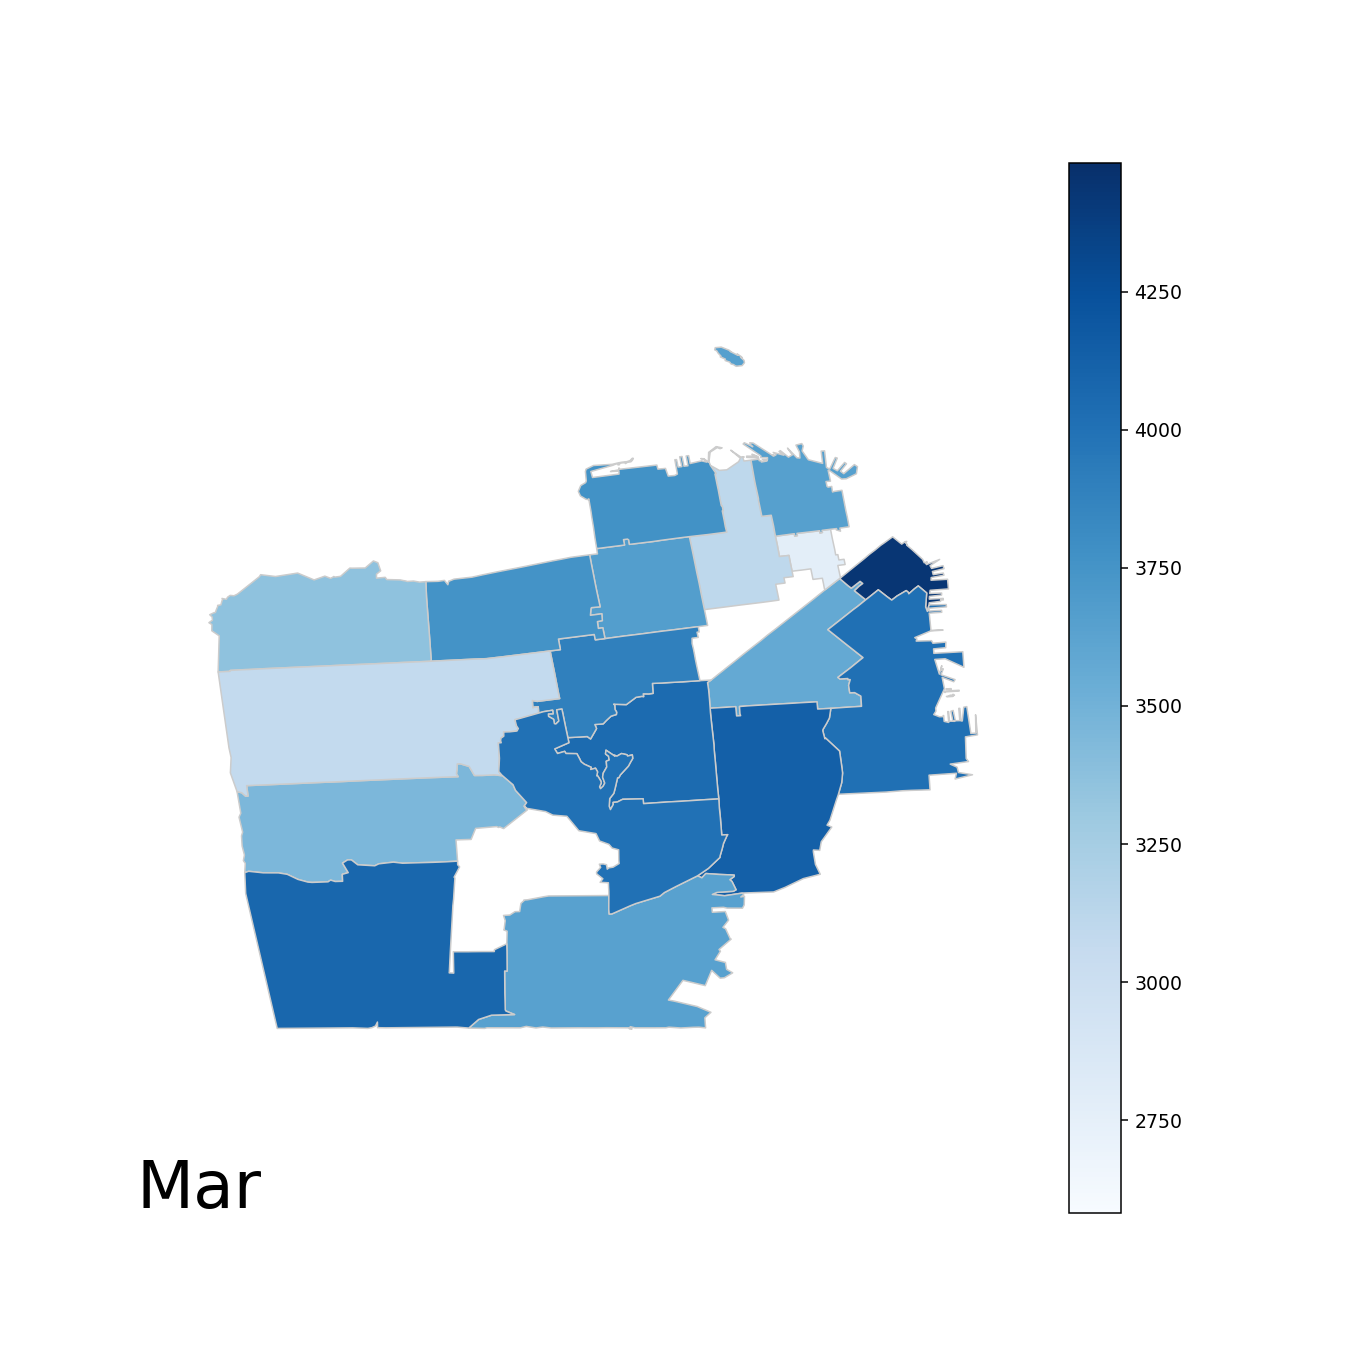

<IPython.core.display.Javascript object>


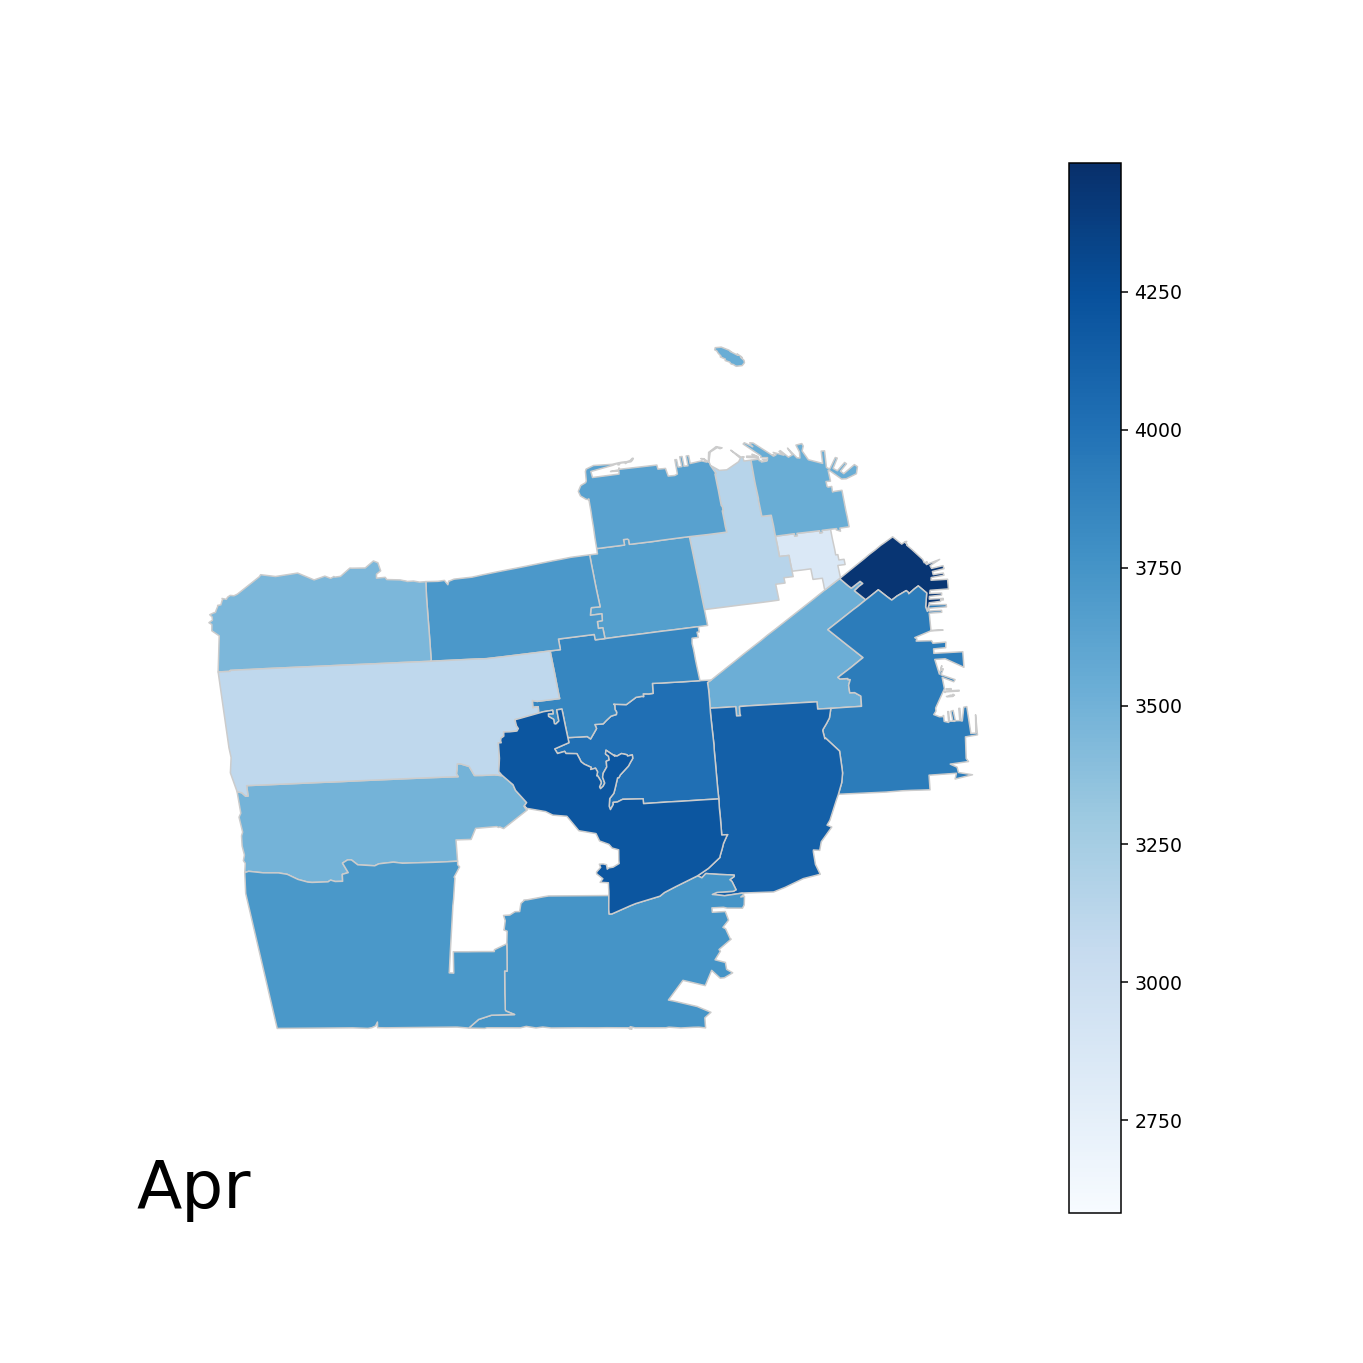

<IPython.core.display.Javascript object>


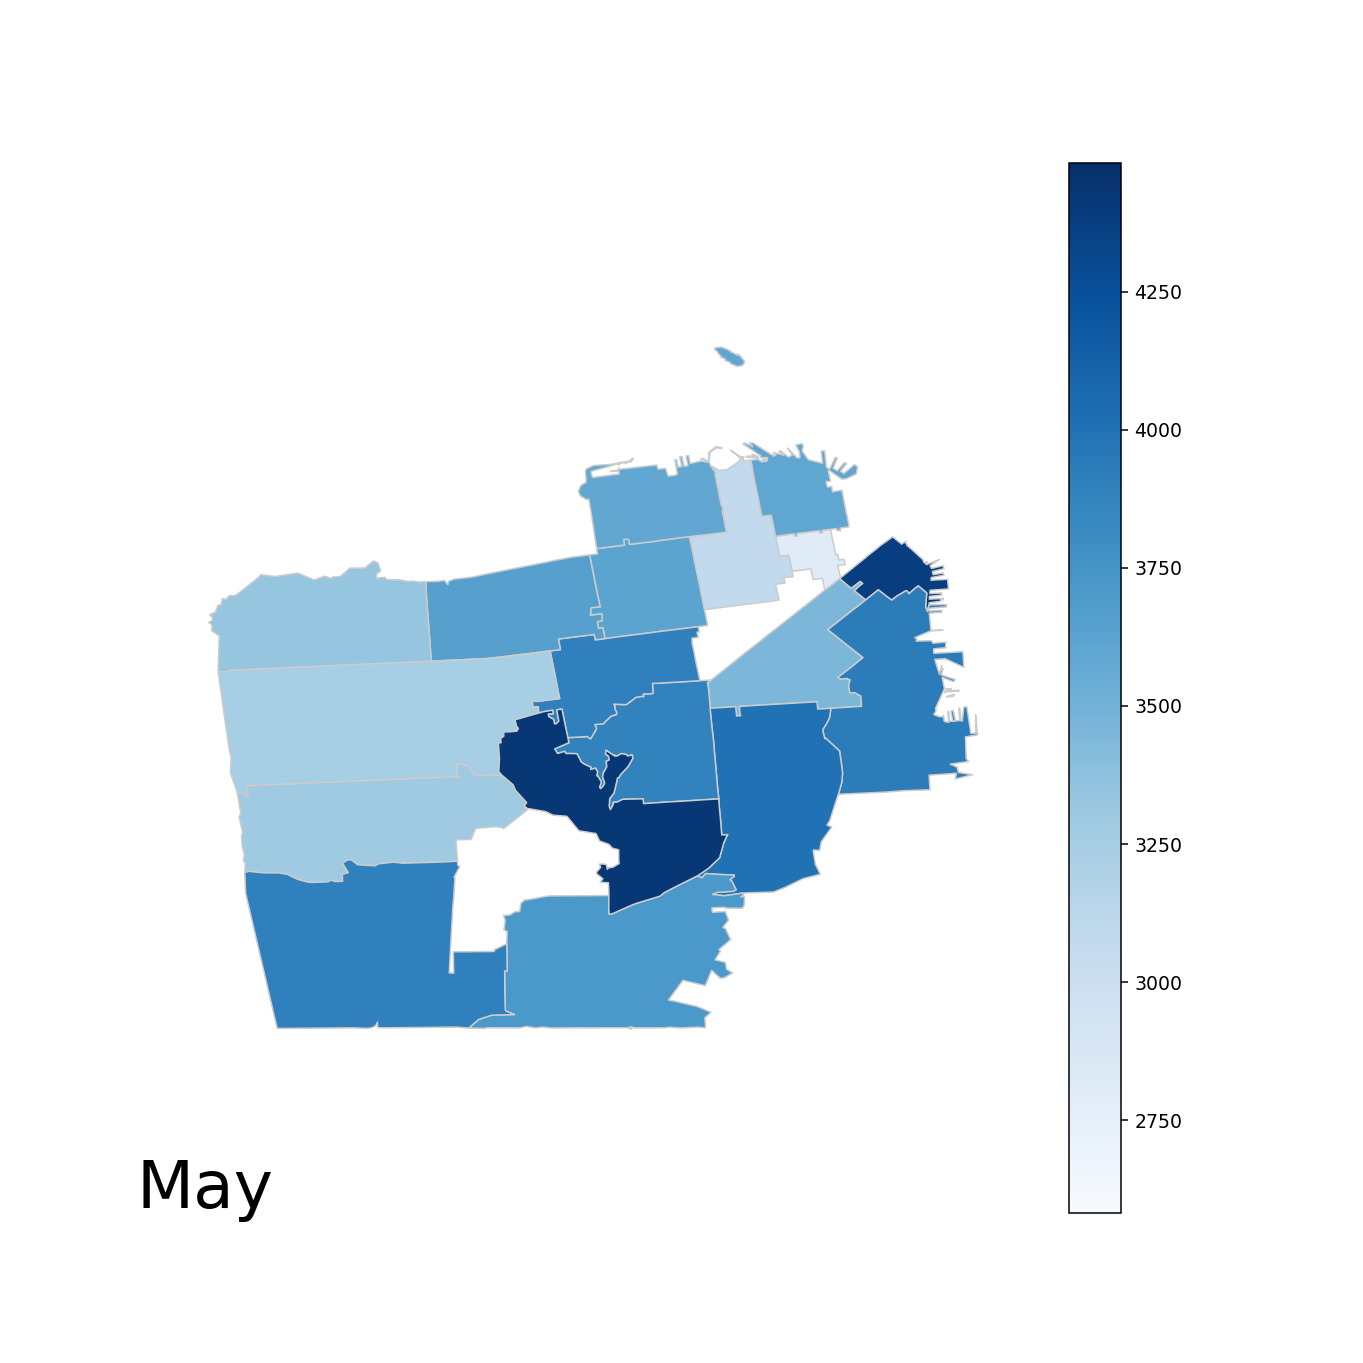

<IPython.core.display.Javascript object>


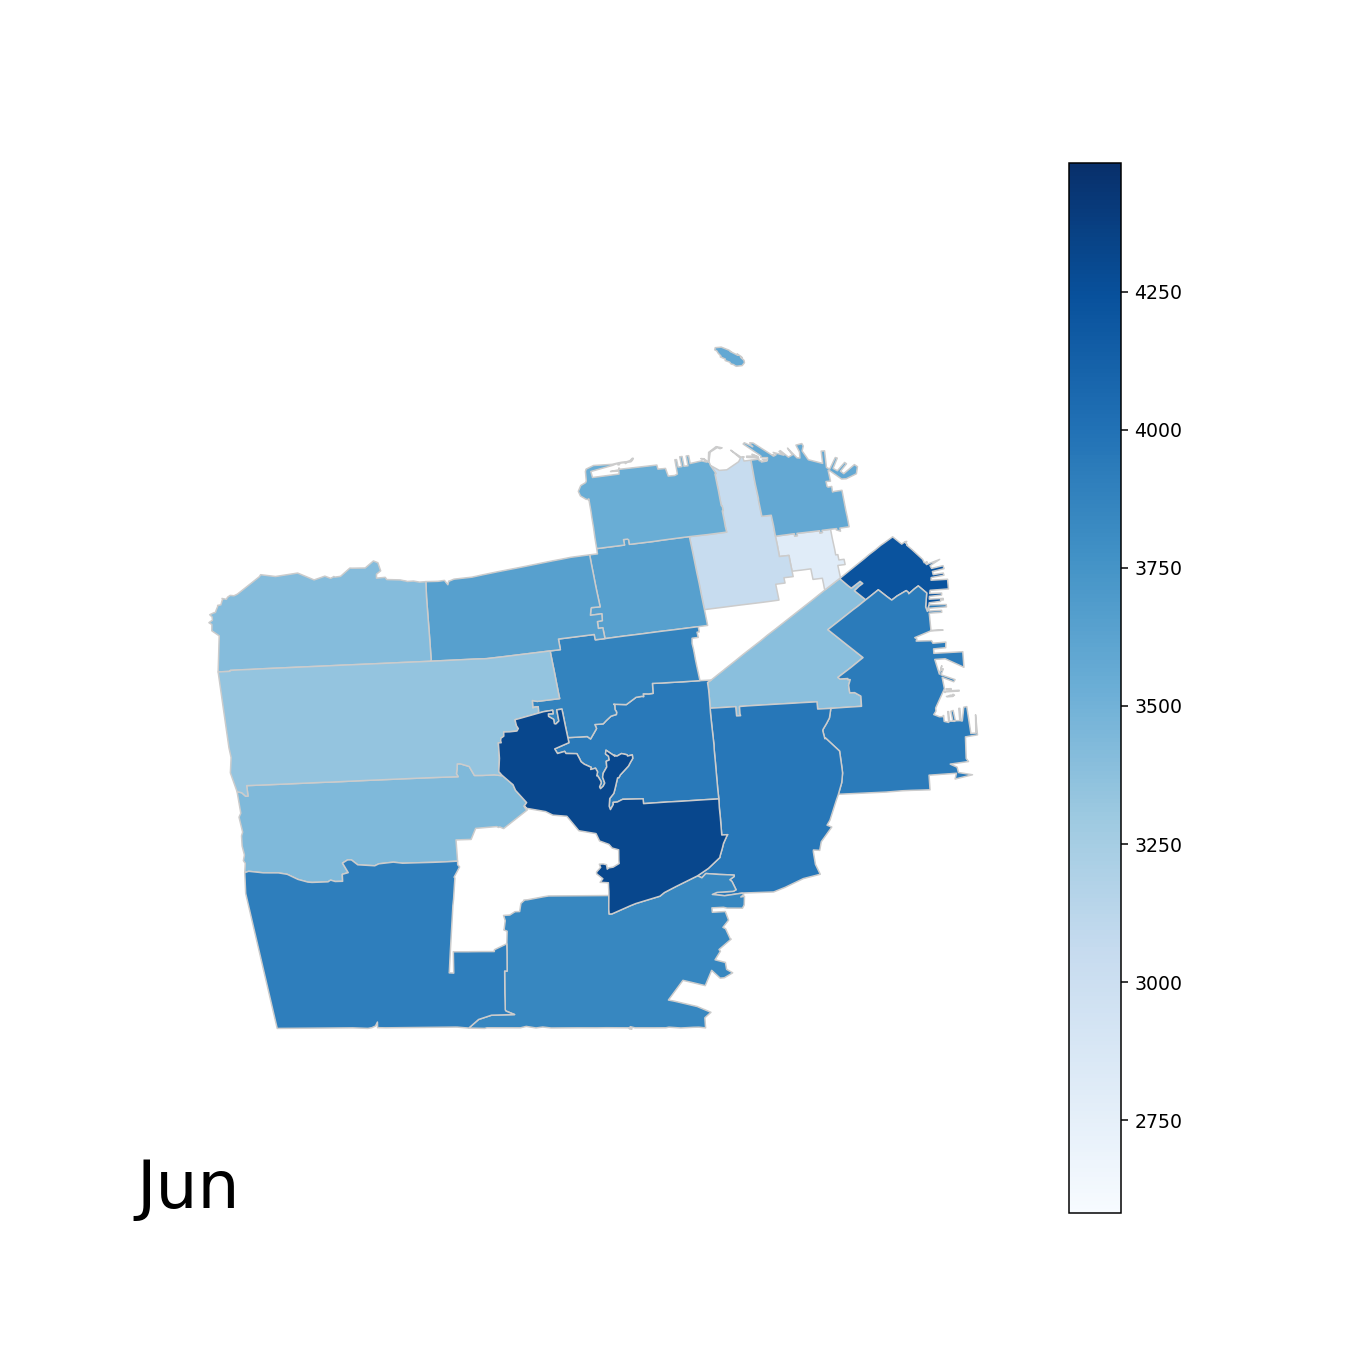

<IPython.core.display.Javascript object>


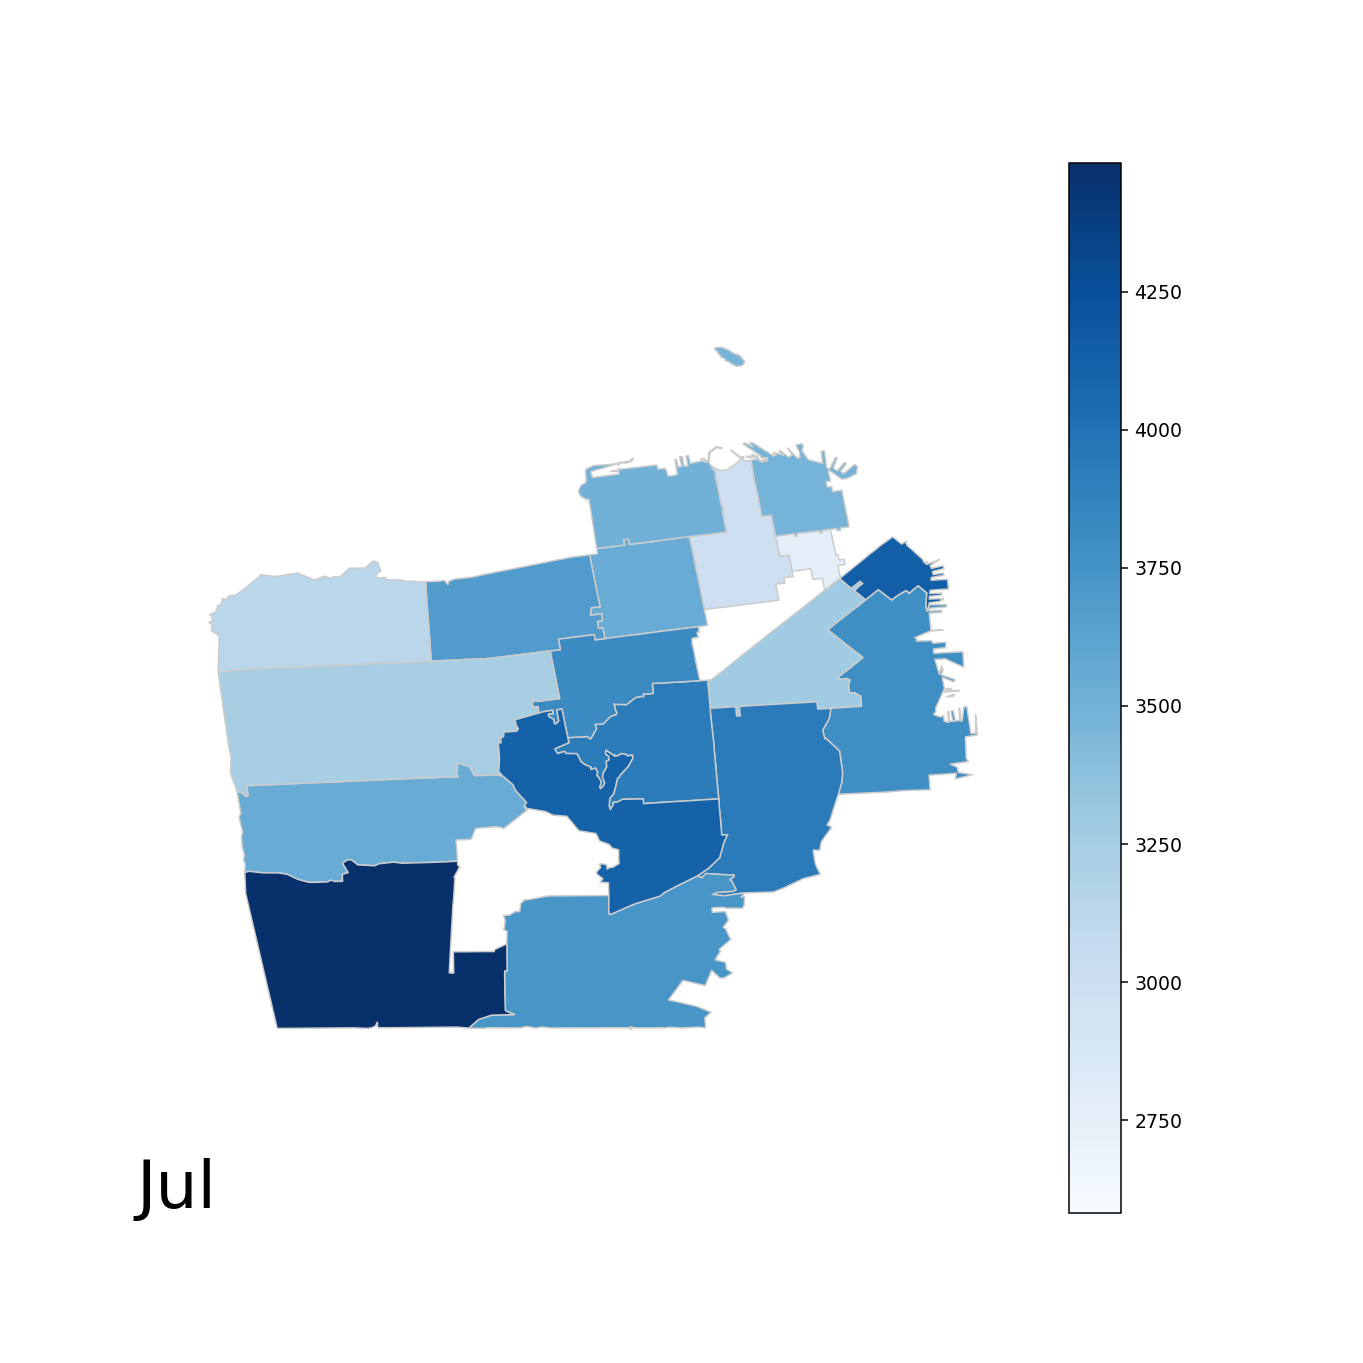

<IPython.core.display.Javascript object>


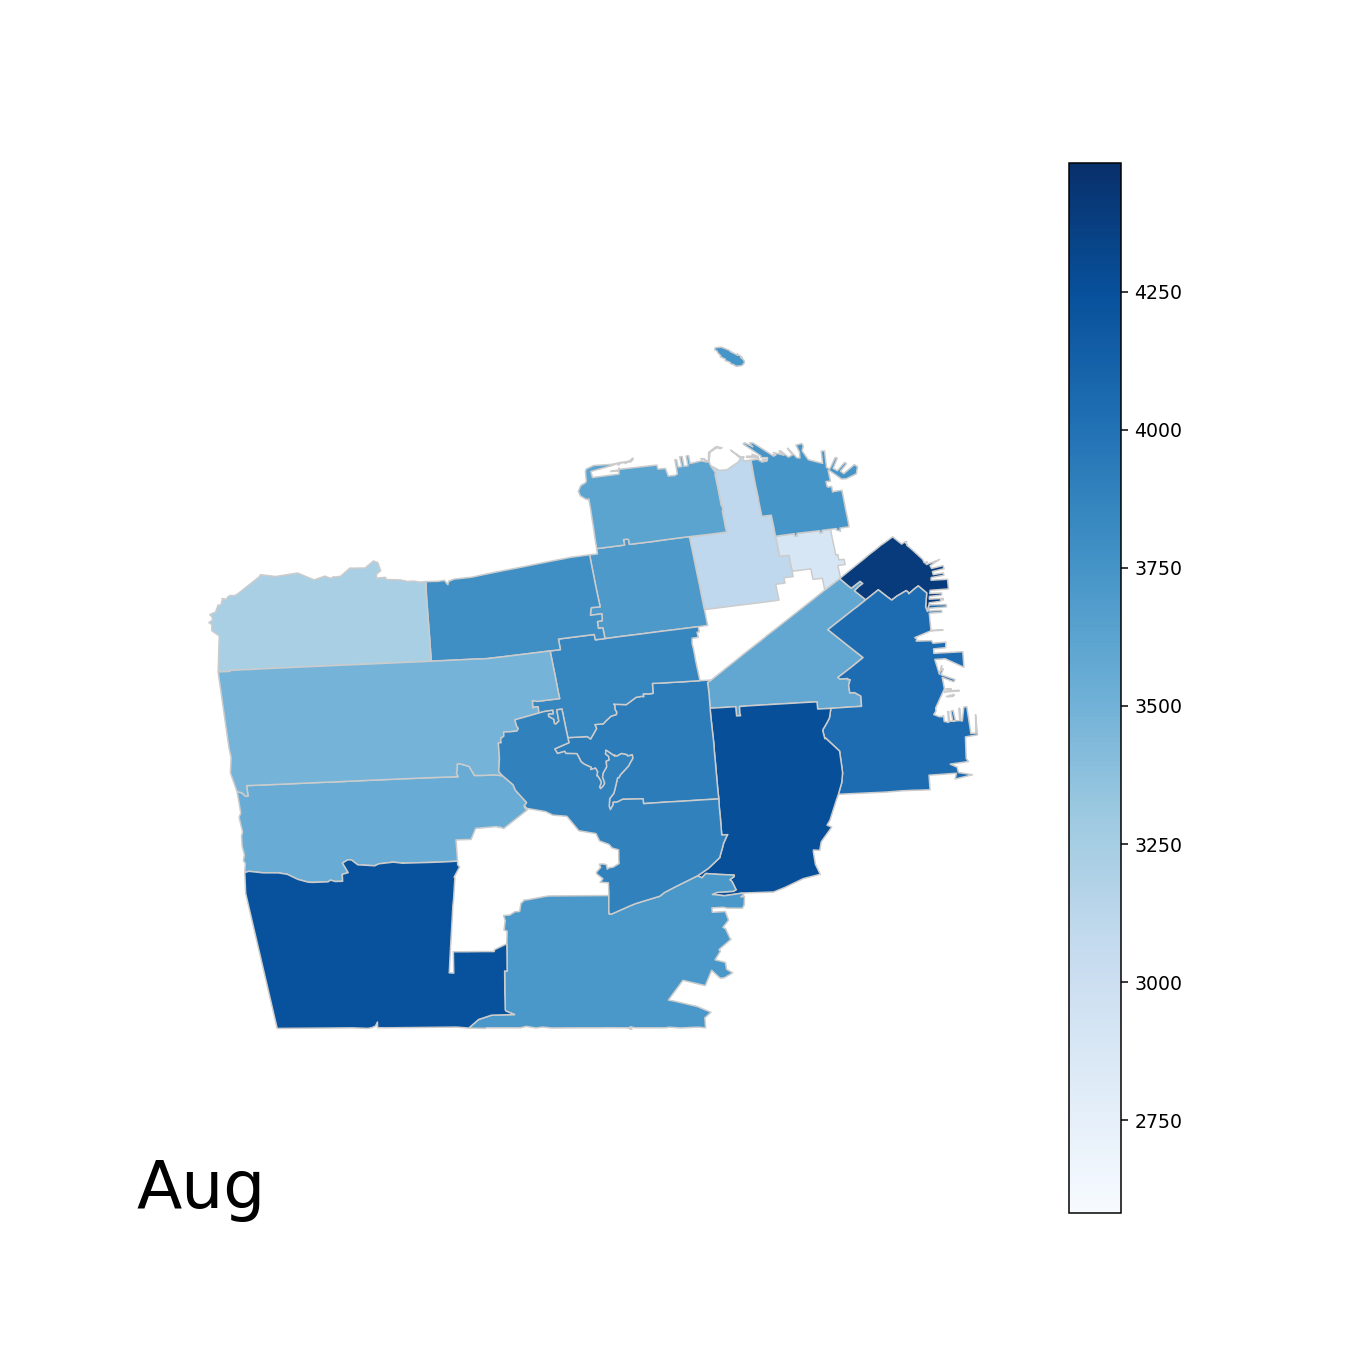

<IPython.core.display.Javascript object>


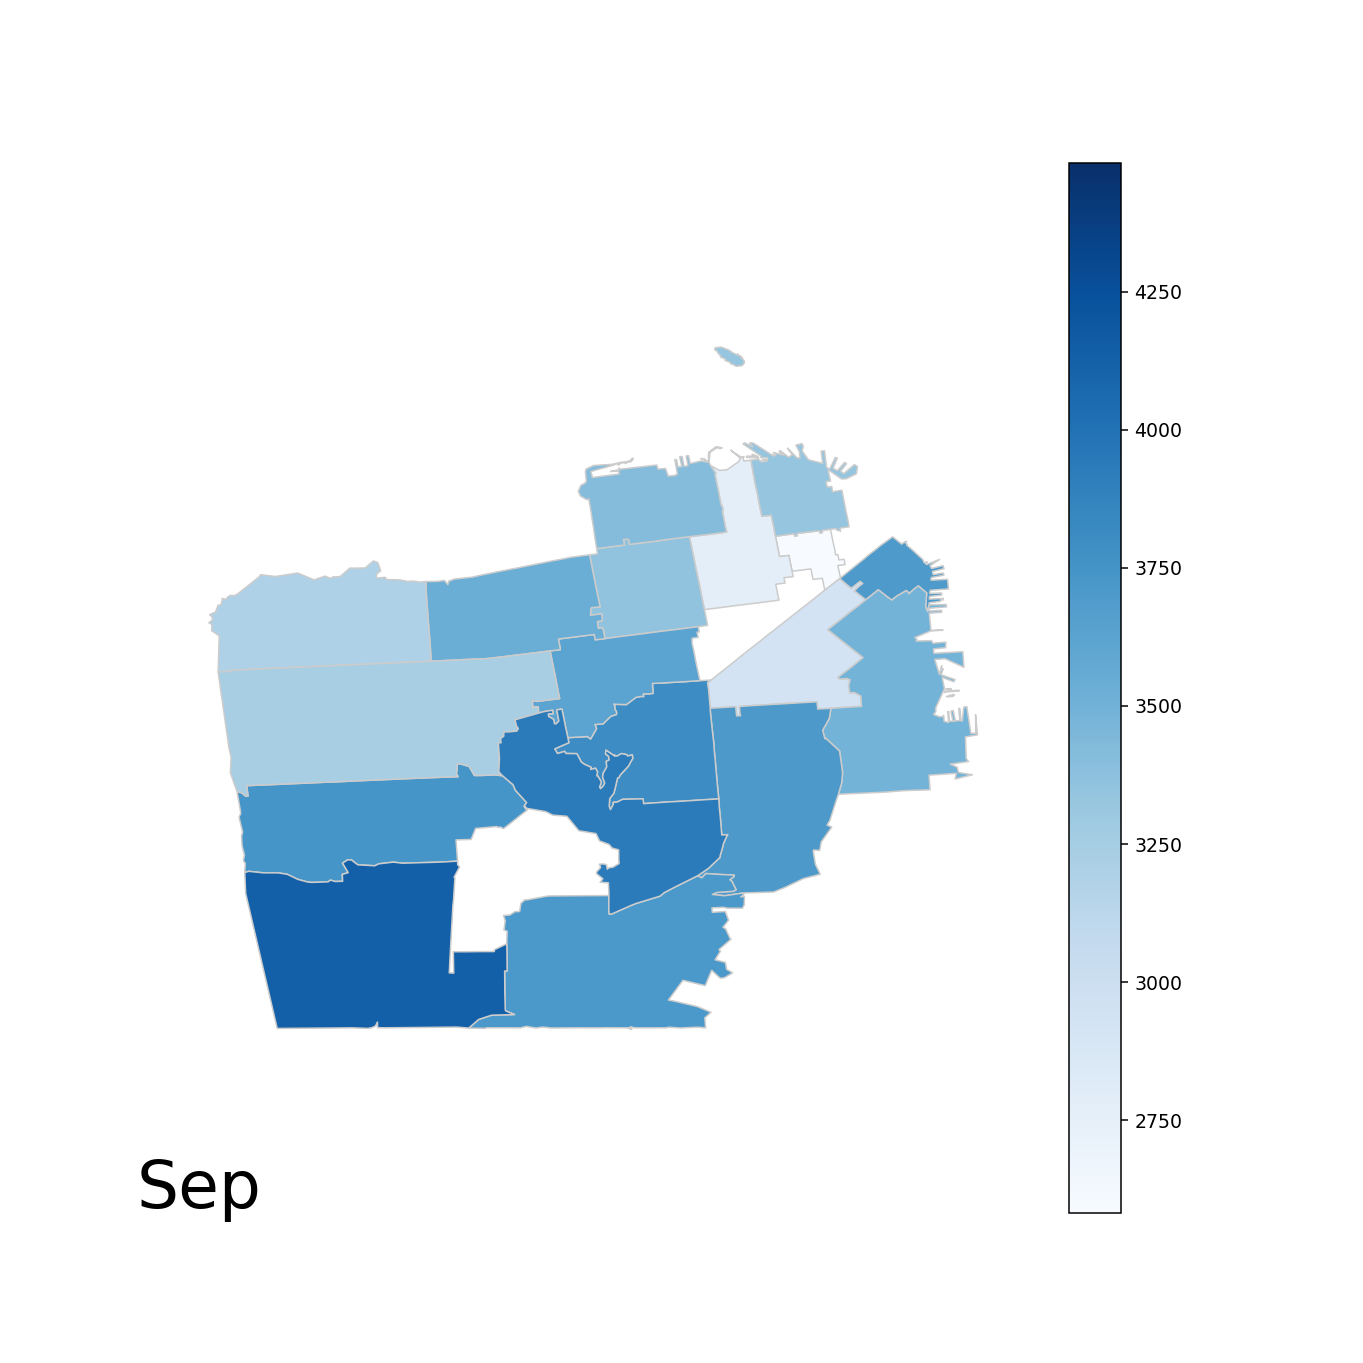

In [579]:
#create maps for each month
for month in list_of_months:
    fig = merged.plot(
        column= month, cmap='Blues', figsize=(10,10), linewidth =.8, edgecolor = '.8',
        vmin=vmin, vmax= vmax, legend = True, norm = plt.Normalize(vmin=vmin, vmax=vmax))
    
    #turn off axis
    fig.axis('off')
    
    #add month label
    fig.annotate(month,
            xy=(0.1, .15), xycoords='figure fraction',
            horizontalalignment='left', verticalalignment='top',
            fontsize=35)  

    #output file
    filepath = os.path.join(output_path, month+'_rent.png')
    chart = fig.get_figure()
    chart.savefig(filepath, dpi=300) 

In [574]:
#use Pillow library to create animated gif


im1 = Image.open('resources/Jan_rent.png')
im2 = Image.open('resources/Feb_rent.png')
im3 = Image.open('resources/Mar_rent.png')
im4 = Image.open('resources/Apr_rent.png')
im5 = Image.open('resources/May_rent.png')
im6 = Image.open('resources/Jun_rent.png')
im7 = Image.open('resources/Jul_rent.png')
im8 = Image.open('resources/Aug_rent.png')
im9 = Image.open('resources/Sep_rent.png')

im1.save(
    'resources/animated_rent.gif',save_all=True, 
    append_images=[im2,im3,im4,im5,im6,im7,im8,im9],
    duration = 800, loop = 0)

In [269]:
#Choropleth zip code interactive map
sep_fig = px.choropleth(merged, geojson= merged.geometry, locations = merged.index,
                    color = 'Sep',hover_name =merged.index)

sep_fig.update_geos(fitbounds="locations", visible=False)

In [266]:
#create dashboard for all figures (not including keplerGL and animated map)
zip_row = pn.Row(rental_by_zip, sep_fig)
geo_column = pn.Column("Rental Rates and Housing Prices", zip_row, housing_fig)
housing_dashboard = pn.Tabs(
    (
        "San Francisco Rental and Housing Market",
        geo_column
    )
)
housing_dashboard.servable()

Tabs
    [0] Column
        [0] Markdown(str)
        [1] Row
            [0] HoloViews(NdOverlay)
            [1] Plotly(Figure)
        [2] Plotly(Figure)